# Dropout

In this notebook, you will implement dropout.  Then we will ask you to train a network with batchnorm and dropout, and acheive over 55% accuracy on CIFAR-10.

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  

In [1]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Dropout forward pass

Implement the training and test time dropout forward pass, `dropout_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [3]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())

Running tests with p =  0.3
Mean of input:  9.998313808847794
Mean of train-time output:  10.015185594642938
Mean of test-time output:  9.998313808847794
Fraction of train-time output set to zero:  0.69944
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  9.998313808847794
Mean of train-time output:  10.007975101174855
Mean of test-time output:  9.998313808847794
Fraction of train-time output set to zero:  0.399376
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  9.998313808847794
Mean of train-time output:  9.998911488980575
Mean of test-time output:  9.998313808847794
Fraction of train-time output set to zero:  0.249968
Fraction of test-time output set to zero:  0.0


## Dropout backward pass

Implement the backward pass, `dropout_backward`, in `nndl/layers.py`.  After that, test your gradients by running the following cell:

In [4]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.8928976558339643e-11


## Implement a fully connected neural network with dropout layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate dropout.  A dropout layer should be incorporated after every ReLU layer.  Concretely, there shouldn't be a dropout at the output layer since there is no ReLU at the output layer. You will need to modify the class in the following areas:

(1) In the forward pass, you will need to incorporate a dropout layer after every relu layer.

(2) In the backward pass, you will need to incorporate a dropout backward pass layer.

Check your implementation by running the following code.  Our W1 gradient relative error is on the order of 1e-6 (the largest of all the relative errors).

In [5]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
  print('\n')

Running check with dropout =  0
Initial loss:  2.305194827376523
W0 relative error: 5.254262643268946e-07
W1 relative error: 1.9848830397288106e-05
W2 relative error: 1.6058572280885614e-07
b0 relative error: 3.2052091264953954e-06
b1 relative error: 1.2013393550446591e-07
b2 relative error: 1.423083336421778e-10


Running check with dropout =  0.25
Initial loss:  2.312646834543345
W0 relative error: 1.4838546739636279e-08
W1 relative error: 2.34278233273103e-10
W2 relative error: 1.2890794099320613e-08
b0 relative error: 1.5292179223310147e-09
b1 relative error: 1.8422707371047494e-10
b2 relative error: 1.5035549207802249e-10


Running check with dropout =  0.5
Initial loss:  2.302437587688794
W0 relative error: 8.781117988653114e-08
W1 relative error: 2.8358418963944355e-08
W2 relative error: 4.3413246357224405e-07
b0 relative error: 3.806557463224407e-09
b1 relative error: 1.3839758741927635e-09
b2 relative error: 1.2806826465527571e-10




## Dropout as a regularizer

In class, we claimed that dropout acts as a regularizer by effectively bagging.  To check this, we will train two small networks, one with dropout and one without dropout.  

In [6]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.6]
for dropout in dropout_choices:
  model = FullyConnectedNet([100, 100, 100], dropout=dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

(Iteration 1 / 125) loss: 2.300804
(Epoch 0 / 25) train acc: 0.220000; val_acc: 0.168000
(Epoch 1 / 25) train acc: 0.188000; val_acc: 0.147000
(Epoch 2 / 25) train acc: 0.266000; val_acc: 0.200000
(Epoch 3 / 25) train acc: 0.338000; val_acc: 0.262000
(Epoch 4 / 25) train acc: 0.378000; val_acc: 0.278000
(Epoch 5 / 25) train acc: 0.428000; val_acc: 0.297000
(Epoch 6 / 25) train acc: 0.468000; val_acc: 0.323000
(Epoch 7 / 25) train acc: 0.494000; val_acc: 0.287000
(Epoch 8 / 25) train acc: 0.566000; val_acc: 0.328000
(Epoch 9 / 25) train acc: 0.572000; val_acc: 0.322000
(Epoch 10 / 25) train acc: 0.622000; val_acc: 0.324000
(Epoch 11 / 25) train acc: 0.670000; val_acc: 0.279000
(Epoch 12 / 25) train acc: 0.710000; val_acc: 0.338000
(Epoch 13 / 25) train acc: 0.746000; val_acc: 0.319000
(Epoch 14 / 25) train acc: 0.792000; val_acc: 0.307000
(Epoch 15 / 25) train acc: 0.834000; val_acc: 0.297000
(Epoch 16 / 25) train acc: 0.876000; val_acc: 0.327000
(Epoch 17 / 25) train acc: 0.886000; val

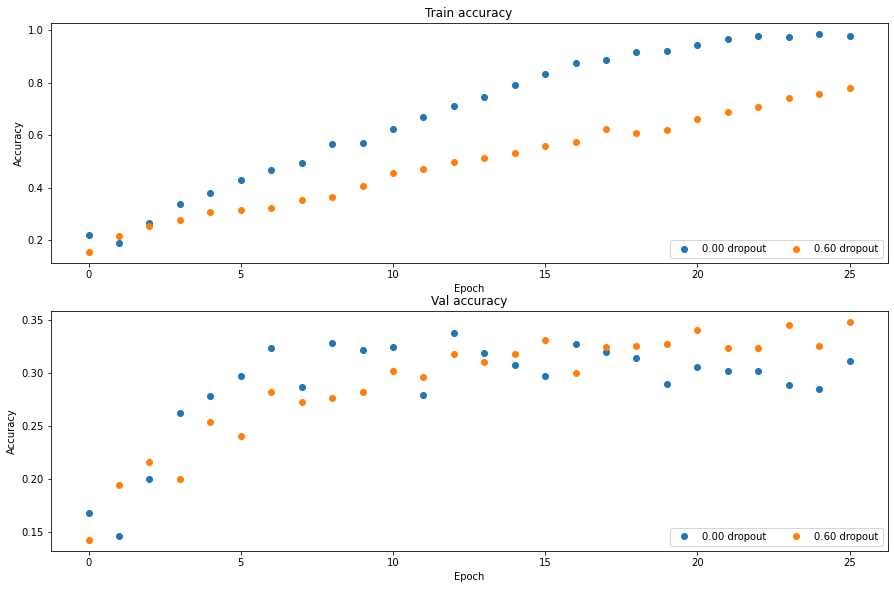

In [7]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Question

Based off the results of this experiment, is dropout performing regularization?  Explain your answer.

## Answer:
Yes dropout is performing regularization as expected. As shown in the training accuracy curves, the training accuracy of the model with 0.6 dropout is lower than the training accuracy of the model without dropout (1.0 versus $\approx$.70 respectively). However, the gap between the validation accuracy of the model with dropout versus without dropout is reduced by a factor of two, revealing that dropout helps with overfitting. Additionally, even though the training accuracy with dropout is smaller than without dropout, the validation accuracy with dropout is significantly larger than without dropout ( $\approx$ .35 versus  $\approx$ .3). 

Therefore, the gap between the training accuracy and the validation accuracy for the model with dropout has become much smaller (which  means overfitting has been prevented/annealed) compared to the gap between the training accuracy and the validation accuracy for the model without dropout (the gap is very large meaning overfitting has occurred), and the validation accuracy with dropout is significantly larger compared to without dropout.

## Final part of the assignment

Get over 55% validation accuracy on CIFAR-10 by using the layers you have implemented.  You will be graded according to the following equation:

min(floor((X - 32%)) / 28%, 1) 
where if you get 60% or higher validation accuracy, you get full points.

In [8]:
from time import time

In [9]:
# ================================================================ #
# YOUR CODE HERE:
#   Implement a FC-net that achieves at least 55% validation accuracy
#   on CIFAR-10.
# ================================================================ #
#optimizer = 'sgd_momentum'
best_model = None

#layer_dims = [420,420,420]
weight_scale = 0.01
#learning_rate = 3e-3
#lr_decay = 0.95

learning_rates = [1e-3]#,5e3]
lr_decays = [.95]
layer_dims = [[700,700,700,700],[600,600,600,600]]
dropouts = [.7]#,.2]
batch_sizes = [150]#,250]
optimizers = ["adam"]

best_val_acc = 0
for i,batch_size in enumerate(batch_sizes):
    for lr_decay in lr_decays:
        for optimizer in optimizers:
            for dropout in dropouts:
                for lr in learning_rates:
                    for layer_dim in layer_dims:
                        print("Outer Loop {}".format(i))
                        print(optimizer,lr,layer_dim,lr_decay,dropout,batch_size)
                        start_time = time()
                        model = FullyConnectedNet(layer_dim, weight_scale=weight_scale,
                                                  use_batchnorm=True,dropout=dropout,reg=1e-4)

                        solver = Solver(model, data,
                                        num_epochs=55, batch_size=batch_size,
                                        update_rule=optimizer,
                                        optim_config={
                                          'learning_rate': lr,
                                        },
                                        lr_decay=lr_decay,
                                        verbose=False)

                        solver.train()

                        if solver.best_val_acc > best_val_acc:
                            best_val_acc = solver.best_val_acc
                            best_params = solver.best_params
                            best_model = solver.model
                            
                        end_time = time()
                        print("Val Accuracy: {}".format(solver.best_val_acc))
                        print("Time in s: ",end_time-start_time)
                        print("--"*50)

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


Outer Loop 0
adam 0.001 [700, 700, 700, 700] 0.95 0.7 150
Val Accuracy: 0.602
Time in s:  4741.734760284424
----------------------------------------------------------------------------------------------------
Outer Loop 0
adam 0.001 [600, 600, 600, 600] 0.95 0.7 150
Val Accuracy: 0.591
Time in s:  4510.058525323868
----------------------------------------------------------------------------------------------------


In [10]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: {}'.format(np.mean(y_val_pred == data['y_val'])))
print('Test set accuracy: {}'.format(np.mean(y_test_pred == data['y_test'])))

Validation set accuracy: 0.615
Test set accuracy: 0.612


## layers.py

In [ ]:
def dropout_forward(x, dropout_param):
    """
    Performs the forward pass for (inverted) dropout.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
    - p: Dropout parameter. We drop each neuron output with probability p.
    - mode: 'test' or 'train'. If the mode is train, then perform dropout;
      if the mode is test, then just return the input.
    - seed: Seed for the random number generator. Passing seed makes this
      function deterministic, which is needed for gradient checking but not in
      real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: A tuple (dropout_param, mask). In training mode, mask is the dropout
    mask that was used to multiply the input; in test mode, mask is None.
    """
    p, mode = dropout_param['p'], dropout_param['mode']
    if 'seed' in dropout_param:
        np.random.seed(dropout_param['seed'])

    mask = None 
    out = None

    if mode == 'train':
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the inverted dropout forward pass during training time.  
    #   Store the masked and scaled activations in out, and store the 
    #   dropout mask as the variable mask.
    # ================================================================ #
        mask = (np.random.rand(*x.shape))<p
        out = (mask*x)/p
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
        pass
    elif mode == 'test':

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the inverted dropout forward pass during test time.
    # ================================================================ #
        out = x
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
        pass
    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache

def dropout_backward(dout, cache):
    """
    Perform the backward pass for (inverted) dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param['mode']

    dx = None
    if mode == 'train':
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the inverted dropout backward pass during training time.
    # ================================================================ #
        dx = mask/dropout_param['p']*dout
        pass
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    elif mode == 'test':
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the inverted dropout backward pass during test time.
    # ================================================================ #
        dx = dout
        pass
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    return dx